In [1]:
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
cols = ['ts_event', 'symbol'] + \
       [f'bid_px_{i:02d}' for i in range(10)] + [f'ask_px_{i:02d}' for i in range(10)] + \
       [f'bid_sz_{i:02d}' for i in range(10)] + [f'ask_sz_{i:02d}' for i in range(10)]
df = pd.read_csv('first_25000_rows.csv', usecols=cols, parse_dates=['ts_event'])
df.sort_values(['symbol','ts_event'], inplace=True)

In [3]:
best_ofi = []
mlofi = [] 

for sym, group in df.groupby('symbol'):
    prev = None
    for _, row in group.iterrows():
        if prev is None:
            best_ofi.append(0.0)
            mlofi.append([0.0]*10)
        else:
            # Best-level OFI (level 0)
            bid_px_old, bid_px_new = prev['bid_px_00'], row['bid_px_00']
            bid_sz_old, bid_sz_new = prev['bid_sz_00'], row['bid_sz_00']
            ask_px_old, ask_px_new = prev['ask_px_00'], row['ask_px_00']
            ask_sz_old, ask_sz_new = prev['ask_sz_00'], row['ask_sz_00']

            e_bid = 0.0
            # Bid side update: addition if price rises or removal if price drops
            if bid_px_old == 0 and bid_px_new > 0:
                e_bid = +bid_sz_new
            elif bid_px_old > 0 and bid_px_new == 0:
                e_bid = -bid_sz_old
            elif bid_px_old > 0 and bid_px_new > 0:
                if bid_px_new >= bid_px_old:
                    e_bid = +bid_sz_new
                else:
                    e_bid = -bid_sz_old

            e_ask = 0.0
            # Ask side update: addition if price drops (more supply) or removal if price rises
            if ask_px_old > 0 and ask_px_new == 0:
                e_ask = +ask_sz_old
            elif ask_px_old == 0 and ask_px_new > 0:
                e_ask = -ask_sz_new
            elif ask_px_old > 0 and ask_px_new > 0:
                if ask_px_new <= ask_px_old:
                    e_ask = -ask_sz_new
                else:
                    e_ask = +ask_sz_old

            best_ofi.append(e_bid + e_ask)

            # Multi-level OFI (levels 0 through 9)
            row_mlofi = []
            for level in range(10):
                # Get old and new price/size at this level
                px_b_old = prev[f'bid_px_{level:02d}']; px_b_new = row[f'bid_px_{level:02d}']
                sz_b_old = prev[f'bid_sz_{level:02d}']; sz_b_new = row[f'bid_sz_{level:02d}']
                px_a_old = prev[f'ask_px_{level:02d}']; px_a_new = row[f'ask_px_{level:02d}']
                sz_a_old = prev[f'ask_sz_{level:02d}']; sz_a_new = row[f'ask_sz_{level:02d}']

                # Compute net flow at this level
                e_bid_lvl = 0.0
                if px_b_old == 0 and px_b_new > 0:
                    e_bid_lvl = +sz_b_new
                elif px_b_old > 0 and px_b_new == 0:
                    e_bid_lvl = -sz_b_old
                elif px_b_old > 0 and px_b_new > 0:
                    if px_b_new >= px_b_old:
                        e_bid_lvl = +sz_b_new
                    else:
                        e_bid_lvl = -sz_b_old

                e_ask_lvl = 0.0
                if px_a_old > 0 and px_a_new == 0:
                    e_ask_lvl = +sz_a_old
                elif px_a_old == 0 and px_a_new > 0:
                    e_ask_lvl = -sz_a_new
                elif px_a_old > 0 and px_a_new > 0:
                    if px_a_new <= px_a_old:
                        e_ask_lvl = -sz_a_new
                    else:
                        e_ask_lvl = +sz_a_old

                row_mlofi.append(e_bid_lvl + e_ask_lvl)
            mlofi.append(row_mlofi)
        prev = row

In [4]:
df_ofi = pd.DataFrame({
    'ts_event': [row.ts_event for sym, group in df.groupby('symbol') for row in group.itertuples()],
    'symbol': [sym for sym, group in df.groupby('symbol') for _ in group.itertuples()],
    'best_ofi': best_ofi
})
for i in range(10):
    df_ofi[f'mlofi_{i}'] = [lvl[i] for lvl in mlofi]

In [5]:
df_ofi['integrated_ofi'] = 0.0
for sym, group in df_ofi.groupby('symbol'):
    X = group[[f'mlofi_{i}' for i in range(10)]].values
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X).flatten()
    df_ofi.loc[group.index, 'integrated_ofi'] = pc1

In [6]:
if df_ofi['symbol'].nunique() > 1:
    # Total integrated OFI at each timestamp
    total_ofi = df_ofi.groupby('ts_event')['integrated_ofi'].transform('sum')
    df_ofi['cross_asset_ofi'] = total_ofi - df_ofi['integrated_ofi']
else:
    df_ofi['cross_asset_ofi'] = 0.0

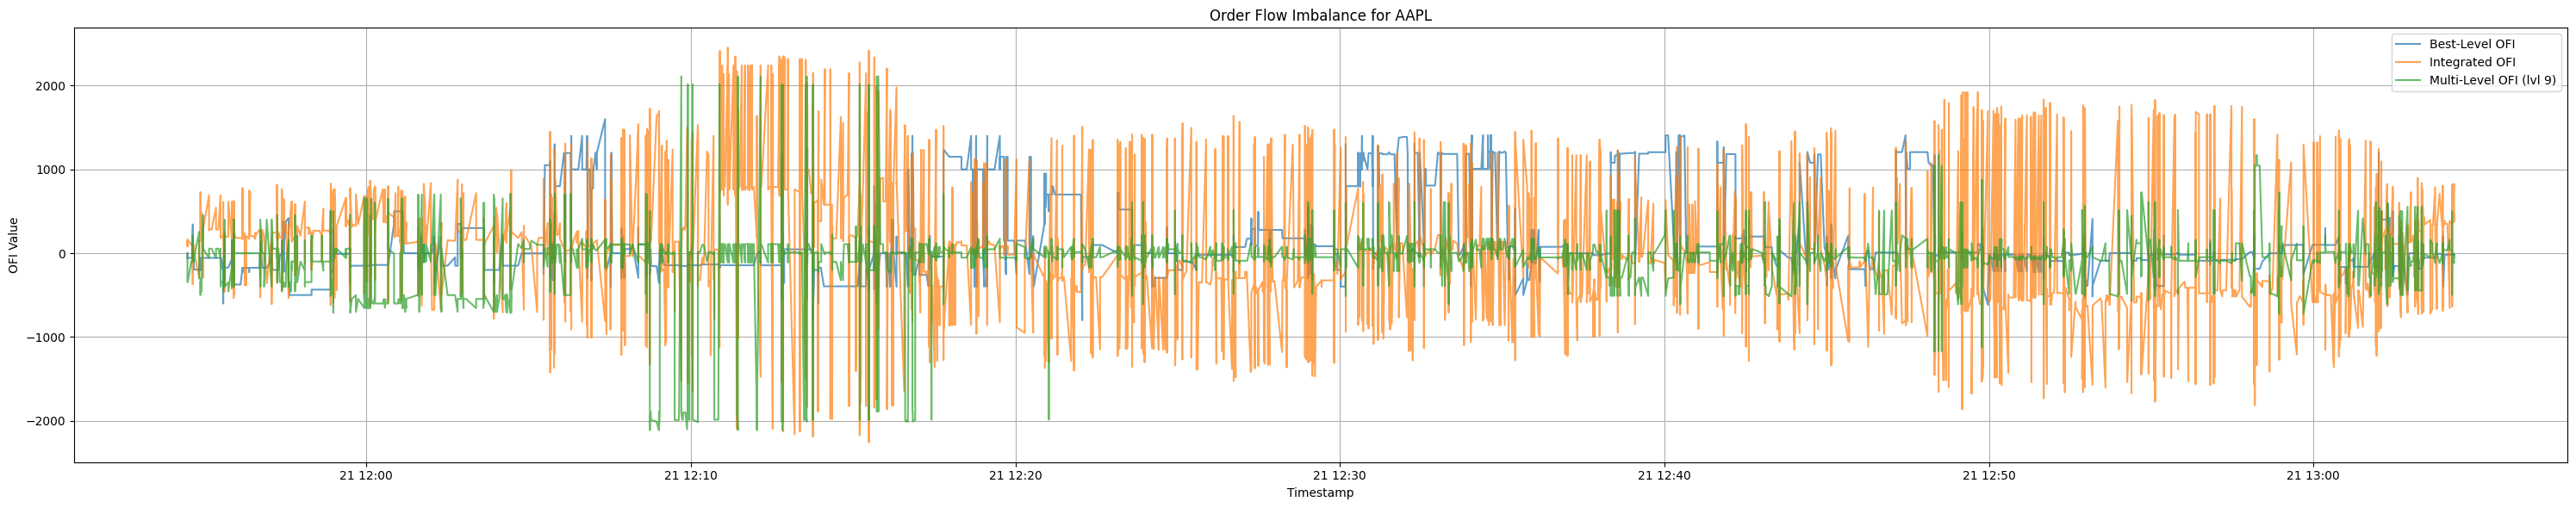

In [40]:
import matplotlib.pyplot as plt

symbol = 'AAPL'
df_plot = df_ofi[df_ofi['symbol'] == symbol].copy()

plt.figure(figsize=(30, 6))
plt.plot(df_plot['ts_event'], df_plot['best_ofi'], label='Best-Level OFI', alpha=0.7)
plt.plot(df_plot['ts_event'], df_plot['integrated_ofi'], label='Integrated OFI', alpha=0.7)
plt.plot(df_plot['ts_event'], df_plot['mlofi_9'], label='Multi-Level OFI (lvl 9)', alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('OFI Value')
plt.title(f'Order Flow Imbalance for {symbol}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


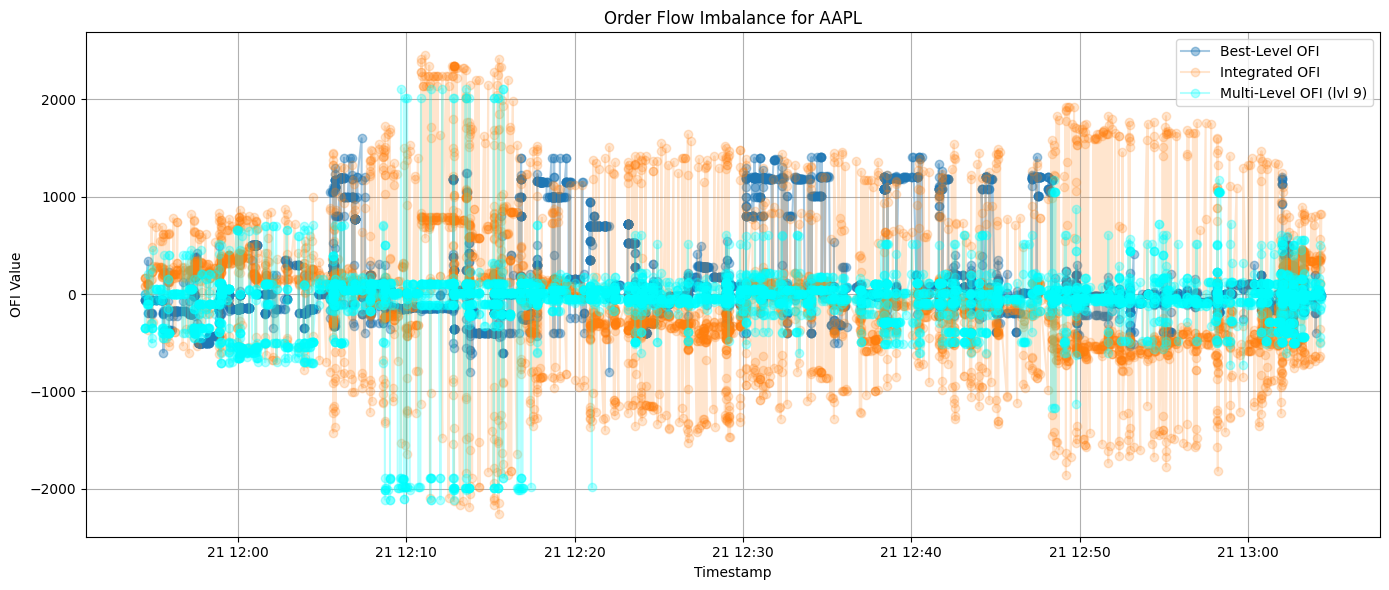

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(df_plot['ts_event'], df_plot['best_ofi'], marker = 'o', label='Best-Level OFI', alpha=0.4)
plt.plot(df_plot['ts_event'], df_plot['integrated_ofi'], marker = 'o', label='Integrated OFI', alpha=0.2)
plt.plot(df_plot['ts_event'], df_plot['mlofi_9'], marker = 'o', label='Multi-Level OFI (lvl 9)', alpha=0.3, color="cyan")

plt.xlabel('Timestamp')
plt.ylabel('OFI Value')
plt.title(f'Order Flow Imbalance for {symbol}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

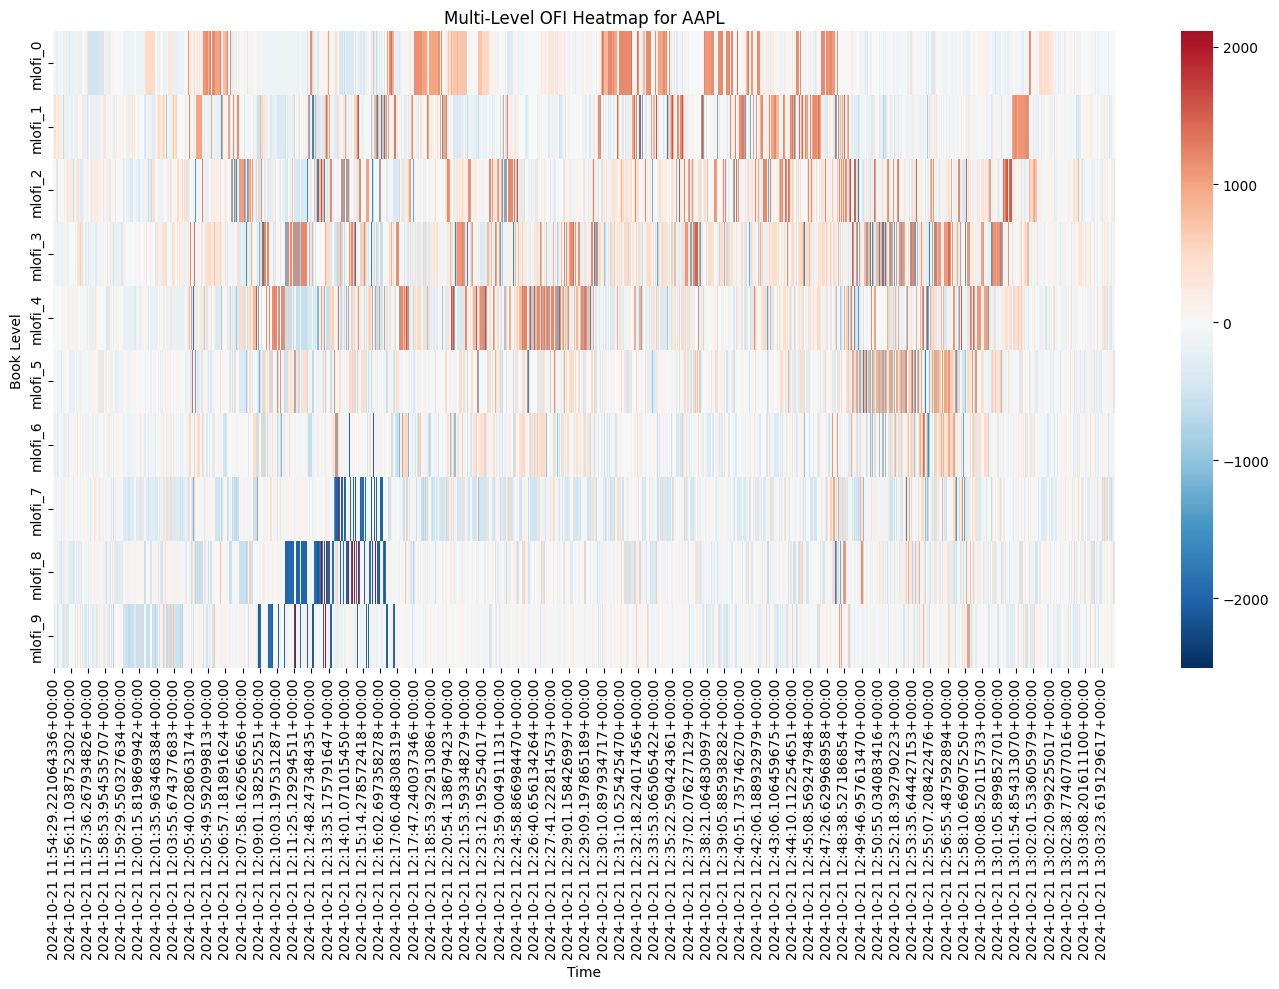

In [27]:
import seaborn as sns

# Create a matrix: rows = time, cols = level, values = OFI
ofi_matrix = df_plot[[f'mlofi_{i}' for i in range(10)]].T
ofi_matrix.columns = df_plot['ts_event'].astype(str)

plt.figure(figsize=(14, 10))
sns.heatmap(ofi_matrix, cmap='RdBu_r', center=0)
plt.title(f'Multi-Level OFI Heatmap for {symbol}')
plt.xlabel('Time')
plt.ylabel('Book Level')
plt.tight_layout()
plt.show()


In [28]:
if df_ofi['symbol'].nunique() > 1:
    symbols = df_ofi['symbol'].unique()
    plt.figure(figsize=(14, 6))
    for sym in symbols:
        df_tmp = df_ofi[df_ofi['symbol'] == sym]
        plt.plot(df_tmp['ts_event'], df_tmp['cross_asset_ofi'], label=f'{sym} - Cross OFI')
    plt.title('Cross-Asset OFI Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Cross-Asset OFI')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# No symbol except AAPL in the data hence no plot